# Apply Decision Tree on Amazon fine food reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given the Amazon fine food review dataset, split the dataset into Train dataset(70%) and Test dataset(30%) based on increasing order of time(recent reviews as Test dataset).

In the t-SNE assignmnet, we have already did the data cleanup like deduplication, stemming, stop-word removal and Lemmatization. So here we are not doing the same thing again. We simply load those stored cleaned text for further analysis.

We are using BoW, TF-IDF, Avg-Word2Vec, TF-IDF-Word2Vec to vectorise the text reviews.

Apply 10-fold cross validation on Train dataset to find optimal hyperparameters for Decision Tree using GridSearch and RandomSearch. Draw confusion matrix to find precision, recall and F1 score.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 


In [101]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import time
import graphviz


# using the SQLite Table to read data
con = sqlite3.connect('final_without_utf8.sqlite') 

#getting the dataset into a dataframe 
final = pd.read_sql_query("""
SELECT * FROM Reviews where ProfileName like "j%" order by Time
""", con) 

#prepare training data points
final_train = pd.read_sql_query("""
SELECT * FROM Reviews where ProfileName like "j%" order by Time 
limit cast(0.7*(select count(*) from Reviews where ProfileName like "j%") as integer) 
""" , con) 

#prepare testing data points
final_test = pd.read_sql_query("""
SELECT * FROM Reviews where ProfileName like "j%" order by Time desc
limit cast(0.3*(select count(*) from Reviews where ProfileName like "j%") as integer) 
""" , con) 

In [102]:
final_train['positiveNegative'] = final_train['positiveNegative'].replace('positive',1)
final_train['positiveNegative'] = final_train['positiveNegative'].replace('negative',0)
final_test['positiveNegative'] = final_test['positiveNegative'].replace('positive',1)
final_test['positiveNegative'] = final_test['positiveNegative'].replace('negative',0)
final_train.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positiveNegative,CleanedText
0,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,1,one movi movi collect fill comedi action whate...
1,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,4,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,1,happen say name three time michael keaten star...
2,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,5,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,1,get crazi look beatlejuic french version video...
3,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,5,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,1,get crazi realli imposs today find french vhs ...
4,346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,5,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",1,great film dont even know sum first complet or...


In [103]:
print(final.shape)
print(final_train.shape)
print(final_test.shape)

(37217, 13)
(26051, 13)
(11165, 13)


In [104]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Bag of Words (BoW)

In [105]:
from sklearn.preprocessing import normalize
count_vect = CountVectorizer() #in scikit-learn
final_train_X = count_vect.fit_transform(final_train['CleanedText'].values)
final_train_Y = final_train['positiveNegative'].values
final_test_X =  count_vect.transform(final_test['CleanedText'].values)
final_test_Y = final_test['positiveNegative'].values

final_train_X = normalize(final_train_X, norm='l1', axis=0)
final_test_X = normalize(final_test_X, norm='l1', axis=0)

unique, counts = np.unique(final_train_Y, return_counts=True)
print("final_train_Y distribution: %s" % dict(zip(unique, counts)))
unique, counts = np.unique(final_test_Y, return_counts=True)
print("final_test_Y distribution: %s" % dict(zip(unique, counts)))
print("So sampling required on the dataset as it has less number of negative datapoints")

final_train_Y distribution: {0: 3876, 1: 22175}
final_test_Y distribution: {0: 1923, 1: 9242}
So sampling required on the dataset as it has less number of negative datapoints


In [107]:
#GridSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(5,51,5)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=tuned_parameters, 
                     scoring = 'roc_auc', cv=10, verbose=False, n_jobs=-1)
model.fit(final_train_X, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 987.2633085250854 seconds


Postive top 10 important features are:
('great', 0.028053778576812547)
('love', 0.015054621794754409)
('disappoint', 0.014959710945045206)
('best', 0.014019152534114622)
('delici', 0.010200143070242501)
('perfect', 0.0061099756263421285)
('bad', 0.005962887303634111)
('favorit', 0.005543584152322499)
('excel', 0.005080575277193483)
('nice', 0.004440498001724684)


Word Cloud for Important features


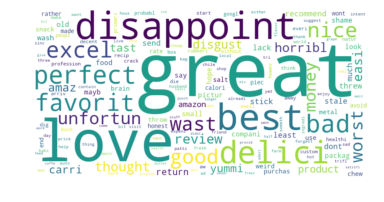

In [117]:
#Inportant features and WordCloud representation
import operator
from sklearn.tree.export import export_graphviz

feature_names= count_vect.get_feature_names()
feat_importance = model.best_estimator_.tree_.compute_feature_importances(normalize=False)
imp_features = {}
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = feat_importance[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

list_of_words=[]
for i in range(len(names_diff_sorted)):
    for j in range(int(names_diff_sorted[i][1]*10000)):
        list_of_words.append(names_diff_sorted[i][0])
list_of_words_str = ' '.join(list_of_words)

wc = WordCloud(background_color="white", max_words=len(list_of_words), 
               width=800, height=400, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

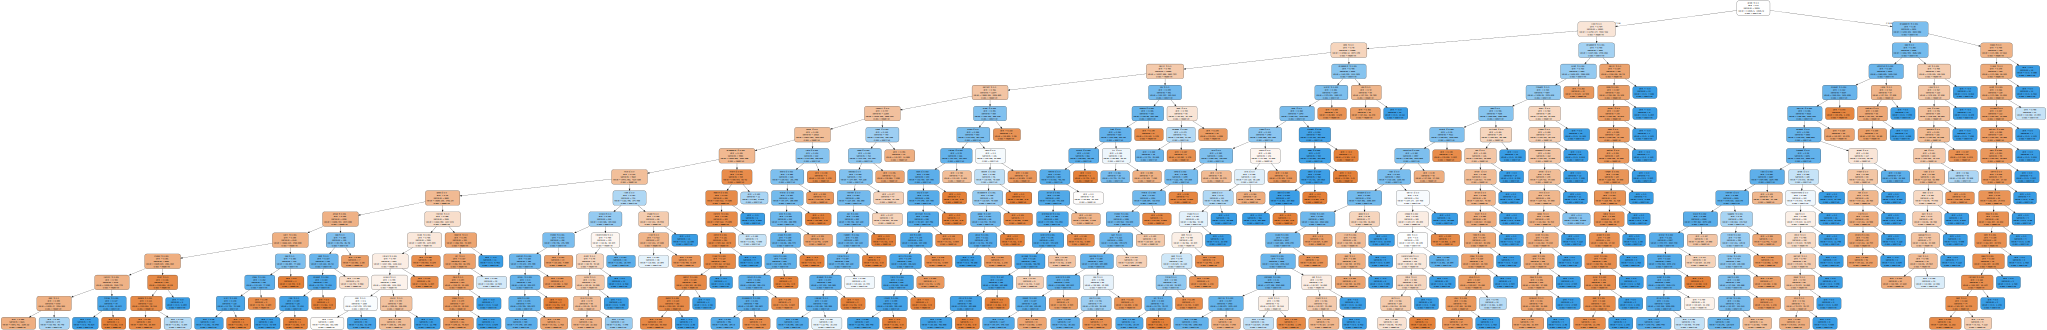

In [118]:
#Drawing visualized Decision Tree
from sklearn.tree import export_graphviz
dot_data = export_graphviz(model.best_estimator_, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['negative','positive'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(source=dot_data, engine='dot')  
graph 


The optimal value of max_depth is 15.


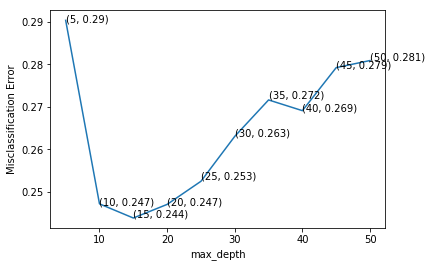

the misclassification error for each max_depth value is :  [0.29  0.247 0.244 0.247 0.253 0.263 0.272 0.269 0.279 0.281]


In [119]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(final_train_X, final_train_Y)
    scores = cross_val_score(estimator=nb, X=final_train_X, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 15  and minimum sample split = 50 is:  66.654725%
Confusion matrix for the model is:


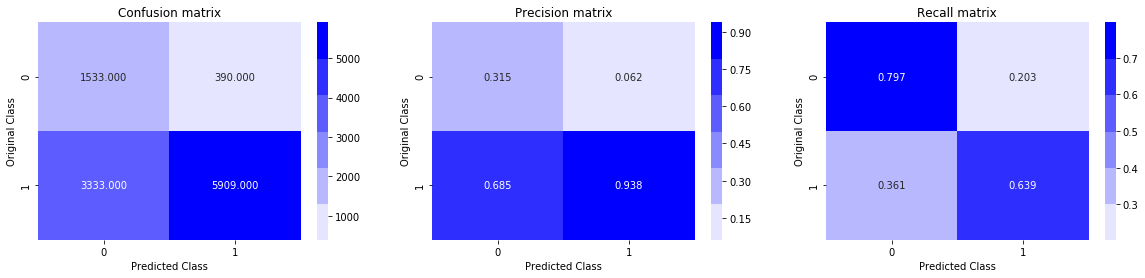

Recall value for the positive class of the model is: 0.6393637740748755
Precision value for the positive class of the model is: 0.9380854103826004
F1 score for the positive class of the model is: 0.7604401261180104


In [120]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [126]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_bow_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(final_train_X)

final_grid_bow_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(final_test_X)

final_grid_bow_test_err=print_auc_score(y_true, y_scores)

#print(final_grid_bow_est)
#print(final_grid_bow_train_err)
#print(final_grid_bow_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
79.23499801629546
71.82778308751914


In [127]:
#RandomizedSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(5,51,5)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_distributions=tuned_parameters, 
                           scoring = 'roc_auc', cv=10, verbose=False) 
model.fit(final_train_X, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 246.2453339099884 seconds


Postive top 10 important features are:
('great', 0.028053778576812478)
('love', 0.015054621794753637)
('disappoint', 0.014604581656170398)
('best', 0.01377791498620937)
('delici', 0.01020014307024474)
('perfect', 0.0063300551305986155)
('bad', 0.005962887303632636)
('favorit', 0.005543584152323651)
('excel', 0.005080575277191458)
('nice', 0.004440498001726044)


Word Cloud for Important features


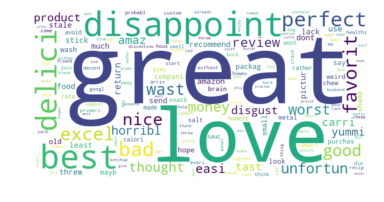

In [128]:
#Inportant features and WordCloud representation
import operator
from sklearn.tree.export import export_graphviz

feature_names= count_vect.get_feature_names()
feat_importance = model.best_estimator_.tree_.compute_feature_importances(normalize=False)
imp_features = {}
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = feat_importance[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

list_of_words=[]
for i in range(len(names_diff_sorted)):
    for j in range(int(names_diff_sorted[i][1]*10000)):
        list_of_words.append(names_diff_sorted[i][0])
list_of_words_str = ' '.join(list_of_words)

wc = WordCloud(background_color="white", max_words=len(list_of_words), 
               width=800, height=400, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

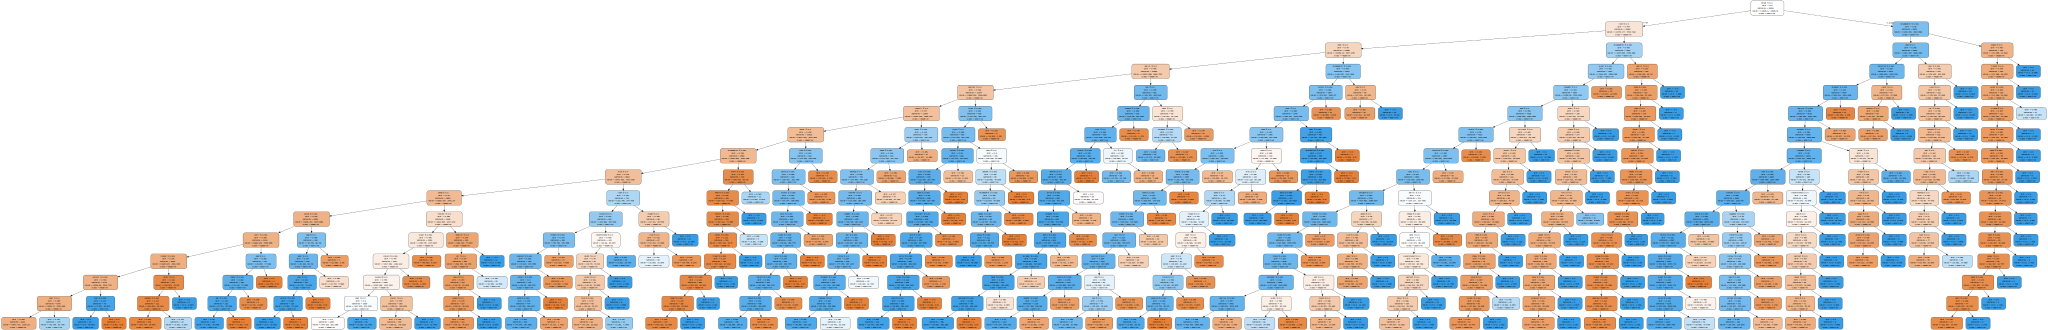

In [129]:
#Drawing visualized Decision Tree
from sklearn.tree import export_graphviz
dot_data = export_graphviz(model.best_estimator_, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['negative','positive'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(source=dot_data, engine='dot')  
graph 


The optimal value of max_depth is 15.


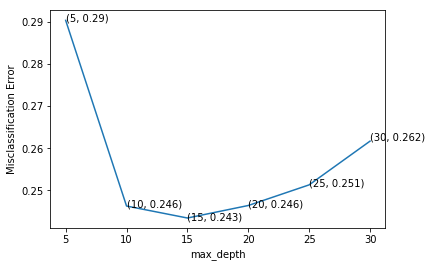

the misclassification error for each max_depth value is :  [0.29  0.246 0.243 0.246 0.251 0.262]


In [130]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(final_train_X, final_train_Y)
    scores = cross_val_score(estimator=nb, X=final_train_X, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 15  and minimum sample split = 50 is:  66.699507%
Confusion matrix for the model is:


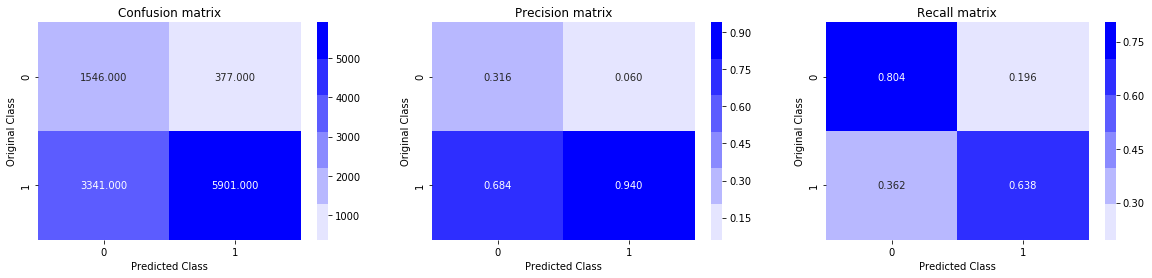

Recall value for the positive class of the model is: 0.6384981605713049
Precision value for the positive class of the model is: 0.9399490283529787
F1 score for the positive class of the model is: 0.760438144329897


In [131]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [133]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_rand_bow_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(final_train_X)

final_rand_bow_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(final_test_X)

final_rand_bow_test_err=print_auc_score(y_true, y_scores)

print(final_rand_bow_est)
print(final_rand_bow_train_err)
print(final_rand_bow_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
79.24401718202265
72.12251593288143


As the no of dimesion in BoW is very high, so it is observed that there is high Training as well as Testing Error.

# TF-IDF

In [134]:
from sklearn.preprocessing import normalize
tf_idf_vect = TfidfVectorizer()
final_train_X = tf_idf_vect.fit_transform(final_train['CleanedText'].values)
to_pass_tfidf_w2v_train = final_train_X
final_train_Y = final_train['positiveNegative'].values
final_test_X =  tf_idf_vect.transform(final_test['CleanedText'].values)
to_pass_tfidf_w2v_test = final_test_X
final_test_Y = final_test['positiveNegative'].values
final_train_X = normalize(final_train_X, norm='l1', axis=0)
final_test_X = normalize(final_test_X, norm='l1', axis=0)

unique, counts = np.unique(final_train_Y, return_counts=True)
print("final_train_Y distribution: %s" % dict(zip(unique, counts)))
unique, counts = np.unique(final_test_Y, return_counts=True)
print("final_test_Y distribution: %s" % dict(zip(unique, counts)))
print("So sampling required on the dataset as it has less number of negative datapoints")

final_train_Y distribution: {0: 3876, 1: 22175}
final_test_Y distribution: {0: 1923, 1: 9242}
So sampling required on the dataset as it has less number of negative datapoints


In [135]:
#GridSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(10,101,10)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=tuned_parameters,
                     scoring = 'roc_auc', cv=10, verbose=False)
model.fit(final_train_X, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 2688.5193943977356 seconds


Postive top 10 important features are:
('great', 0.028323028802142124)
('love', 0.01657044719049736)
('disappoint', 0.015569366567670585)
('best', 0.01523512265774195)
('delici', 0.01102894008943764)
('perfect', 0.007221088452962943)
('good', 0.00573829003446603)
('favorit', 0.005708700134288707)
('excel', 0.00542564939334423)
('nice', 0.004172628866112721)


Word Cloud for Important features


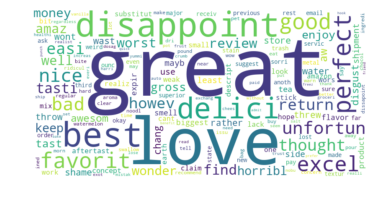

In [136]:
#Inportant features and WordCloud representation
import operator
from sklearn.tree.export import export_graphviz

feature_names= tf_idf_vect.get_feature_names()
feat_importance = model.best_estimator_.tree_.compute_feature_importances(normalize=False)
imp_features = {}
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = feat_importance[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

list_of_words=[]
for i in range(len(names_diff_sorted)):
    for j in range(int(names_diff_sorted[i][1]*10000)):
        list_of_words.append(names_diff_sorted[i][0])
list_of_words_str = ' '.join(list_of_words)

wc = WordCloud(background_color="white", max_words=len(list_of_words), 
               width=800, height=400, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

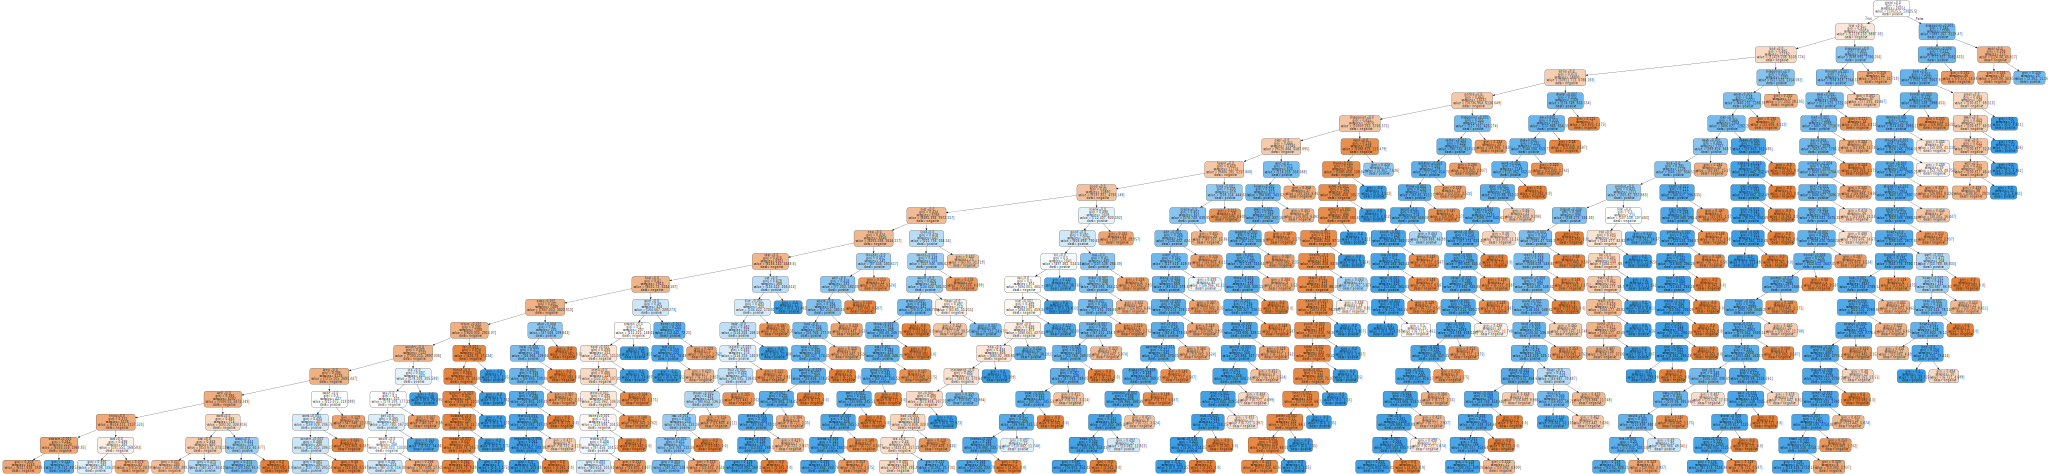

In [137]:
#Drawing visualized Decision Tree
from sklearn.tree import export_graphviz
dot_data = export_graphviz(model.best_estimator_, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['negative','positive'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(source=dot_data, engine='dot')  
graph


The optimal value of max_depth is 15.


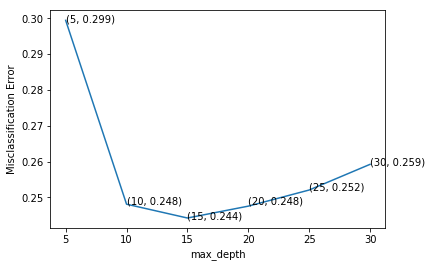

the misclassification error for each max_depth value is :  [0.299 0.248 0.244 0.248 0.252 0.259]


In [138]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(final_train_X, final_train_Y)
    scores = cross_val_score(estimator=nb, X=final_train_X, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 20  and minimum sample split = 100 is:  71.849530%
Confusion matrix for the model is:


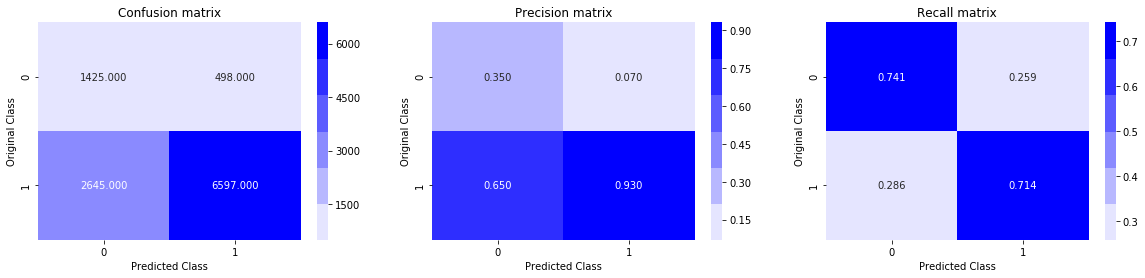

Recall value for the positive class of the model is: 0.7138065353819519
Precision value for the positive class of the model is: 0.9298097251585624
F1 score for the positive class of the model is: 0.8076146171267675


In [139]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [140]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_tfidf_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(final_train_X)

final_grid_tfidf_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(final_test_X)

final_grid_tfidf_test_err=print_auc_score(y_true, y_scores)

print(final_grid_tfidf_est)
print(final_grid_tfidf_train_err)
print(final_grid_tfidf_test_err)


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
81.9926248075923
72.74180882837997


In [143]:
#RandomizedSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(1,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_distributions=tuned_parameters, 
                           scoring = 'roc_auc', cv=10, verbose=False)
model.fit(final_train_X, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=251,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 244.0585012435913 seconds


Postive top 10 important features are:
('great', 0.028072516703366943)
('love', 0.01634760363343697)
('disappoint', 0.015569366567671026)
('best', 0.01497471868287054)
('delici', 0.011028940089433068)
('perfect', 0.0072210884529576354)
('good', 0.005738290034468234)
('favorit', 0.005708700134289265)
('excel', 0.005425649393343846)
('nice', 0.0041726288661127296)


Word Cloud for Important features


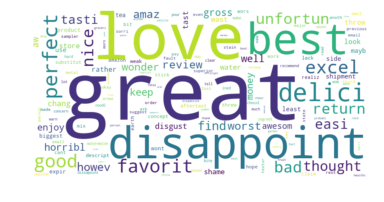

In [144]:
#Inportant features and WordCloud representation
import operator
from sklearn.tree.export import export_graphviz

feature_names= tf_idf_vect.get_feature_names()
feat_importance = model.best_estimator_.tree_.compute_feature_importances(normalize=False)
imp_features = {}
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = feat_importance[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

list_of_words=[]
for i in range(len(names_diff_sorted)):
    for j in range(int(names_diff_sorted[i][1]*10000)):
        list_of_words.append(names_diff_sorted[i][0])
list_of_words_str = ' '.join(list_of_words)

wc = WordCloud(background_color="white", max_words=len(list_of_words), 
               width=800, height=400, collocations=False)
wc.generate(list_of_words_str)
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

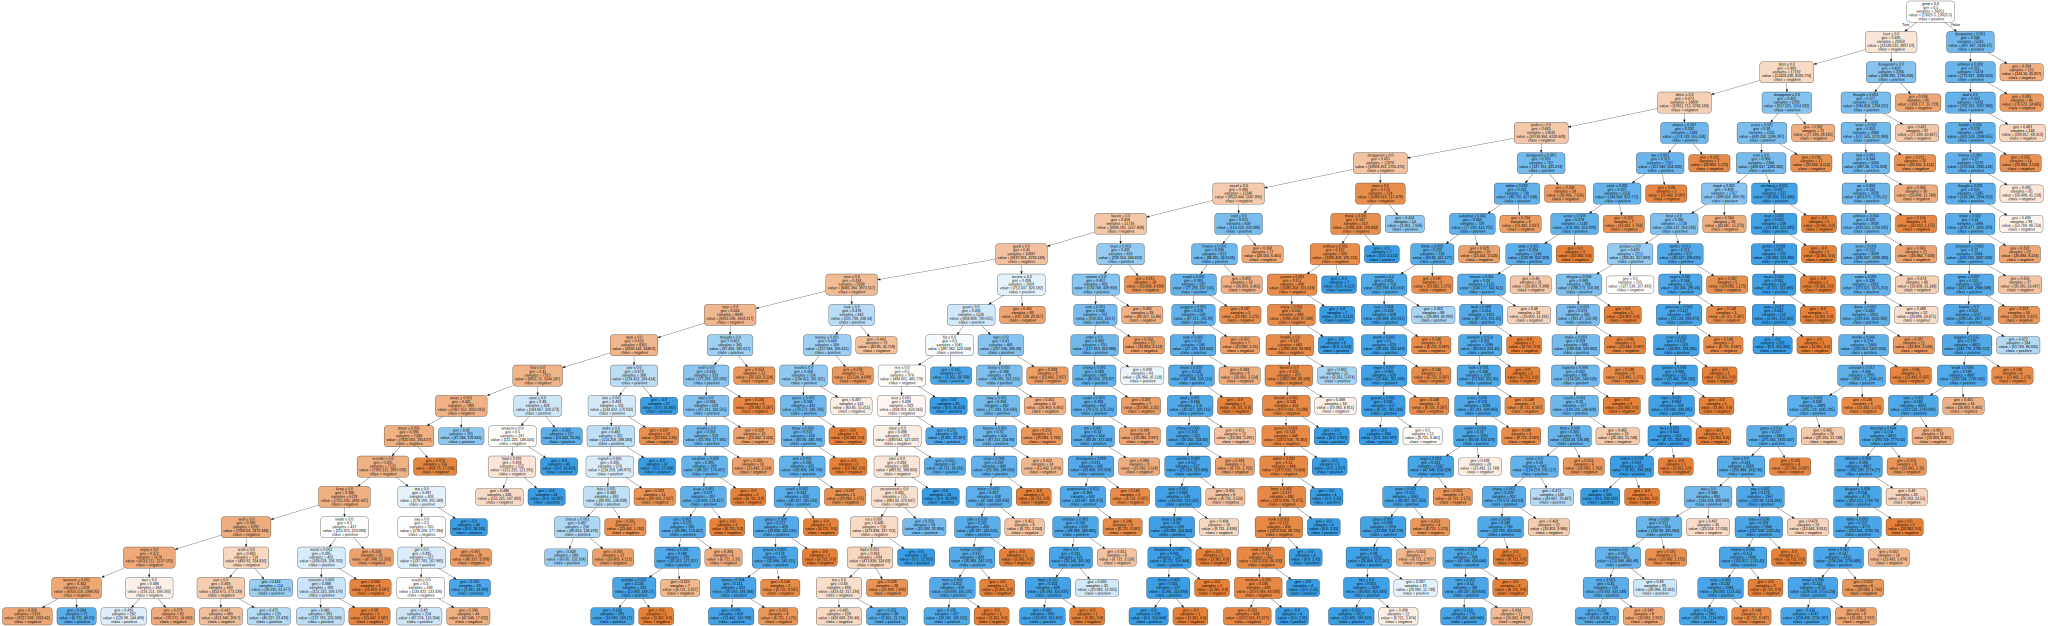

In [145]:
#Drawing visualized Decision Tree
from sklearn.tree import export_graphviz
dot_data = export_graphviz(model.best_estimator_, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['negative','positive'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(source=dot_data, engine='dot')  
graph 


The optimal value of max_depth is 20.


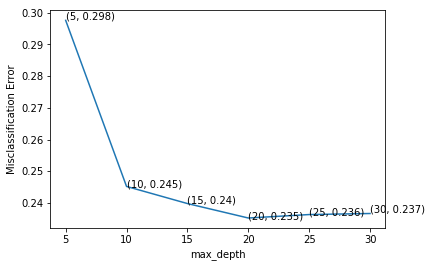

the misclassification error for each max_depth value is :  [0.298 0.245 0.24  0.235 0.236 0.237]


In [146]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(final_train_X, final_train_Y)
    scores = cross_val_score(estimator=nb, X=final_train_X, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 20  and minimum sample split = 251 is:  71.634572%
Confusion matrix for the model is:


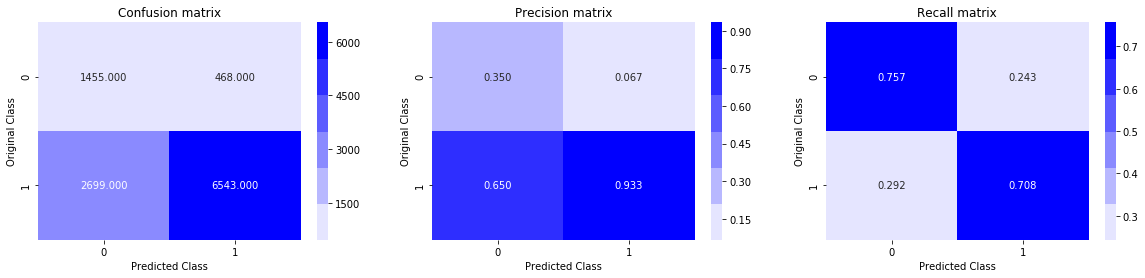

Recall value for the positive class of the model is: 0.7079636442328501
Precision value for the positive class of the model is: 0.9332477535301669
F1 score for the positive class of the model is: 0.8051436657847783


In [147]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [148]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_rand_tfidf_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(final_train_X)

final_rand_tfidf_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(final_test_X)

final_rand_tfidf_test_err=print_auc_score(y_true, y_scores)

print(final_rand_tfidf_est)
print(final_rand_tfidf_train_err)
print(final_rand_tfidf_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=251,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
80.90313006470018
73.22969547217292


Here also the no of dimesion in TF-IDF is very high, so it is observed that there is high Training error/Testing Error

#  Word2Vec

In [149]:
# Using Google News Word2Vectors
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('amazon-fine-food-reviews/GoogleNews-vectors-negative300.bin', binary=True)

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned



In [150]:
# Train your own Word2Vec model using your own text corpus
import re
i=0
final_train_X=[]
final_train_Y=[]
for sents in final_train.values:
    filtered_sentence=[]
    #print(sents[final_train.columns.get_loc("CleanedText")])
    sent=cleanhtml(sents[final_train.columns.get_loc("CleanedText")])
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    final_train_X.append(filtered_sentence)
    final_train_Y.append(sents[final_train.columns.get_loc("positiveNegative")])
    

i=0
final_test_X=[]
final_test_Y=[]
for sents in final_test.values:
    filtered_sentence=[]
    #print(sents[final_train.columns.get_loc("CleanedText")])
    sent=cleanhtml(sents[final_test.columns.get_loc("CleanedText")])
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    final_test_X.append(filtered_sentence)
    final_test_Y.append(sents[final_test.columns.get_loc("positiveNegative")])
    
    

In [151]:
w2v_model=gensim.models.Word2Vec(final_train_X,min_count=5, workers=4, size =50)    #size=50,
print(w2v_model)
#print(final_train_X[1])
#w2v_model.wv[final_train_X[1][3]]


Word2Vec(vocab=6911, size=50, alpha=0.025)


#  Average W2V

In [170]:
# average Word2Vec
# compute average word2vec for each training review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in final_train_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print(sent_vectors_train[1])


min_val=1
for i in range(0,len(sent_vectors_train)):
    for j in range(0,len(sent_vectors_train[0])):
        if sent_vectors_train[i][j] < min_val:
            min_val = sent_vectors_train[i][j]
        else:
            continue

            
# average Word2Vec
# compute average word2vec for each testing review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in final_test_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
print(sent_vectors_test[1])

#We fould 1 review(19948) has all the vectors as Nan. So we are replacing it with 0
for i in range(len(sent_vectors_train)):
    for j in range(50):
        if sent_vectors_train[i][j] != sent_vectors_train[i][j]:
            sent_vectors_train[i][j]=0


min_val=1
for i in range(0,len(sent_vectors_test)):
    for j in range(0,len(sent_vectors_test[0])):
        if sent_vectors_test[i][j] < min_val:
            min_val = sent_vectors_test[i][j]
        else:
            continue

            


26051
50
[ 0.57142368 -0.03073194  0.42368384  0.16235748  0.25187699 -0.07262655
  0.04463706  0.35685478 -0.1951092   0.0716298  -0.13020067  0.20878707
  0.00260429 -0.39801175  0.11569458  0.33249776 -0.28984305  0.00949082
  0.42351634 -0.16758569 -0.00461513  0.05267552  0.44370497 -0.09438225
 -0.43196896  0.08798218  0.03631792 -0.25299436 -0.55775285 -0.2714372
 -0.36375611  0.21406465 -0.04315161  0.05686421  0.1601911  -0.00496086
 -0.41836866 -0.5089587   0.15168937  0.64599827 -0.55892243  0.4492825
  0.05481203 -0.1191597  -0.56840984 -0.34062553  0.14580032  0.46714971
 -0.02322606  0.04777422]
11165
50
[ 0.37559123 -0.12607492  0.34504116  0.04660168 -0.03384731 -0.06685998
  0.16703613  0.19988823 -0.17787976 -0.03206742  0.02987427  0.27683866
 -0.03706002 -0.38354203  0.01877522  0.34742404 -0.32712433 -0.1544776
  0.25086424 -0.3224743   0.10967725 -0.07589618  0.35903837 -0.03133957
 -0.26566126  0.01675282  0.04308815 -0.42151178 -0.51100903 -0.26227246
 -0.302251

In [178]:
print(sent_vectors_train[19948])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [176]:
#GridSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=tuned_parameters, 
                     scoring = 'roc_auc', cv=10, verbose=False)
model.fit(sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 1205.4283640384674 seconds



The optimal value of max_depth is 5.


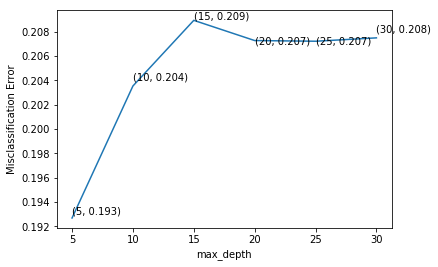

the misclassification error for each max_depth value is :  [0.193 0.204 0.209 0.207 0.207 0.208]


In [180]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,max_depth=k, class_weight='balanced')
    nb.fit(sent_vectors_train, final_train_Y)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(estimator=nb, X=sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 5  and minimum sample split = 252 is:  72.745186%
Confusion matrix for the model is:


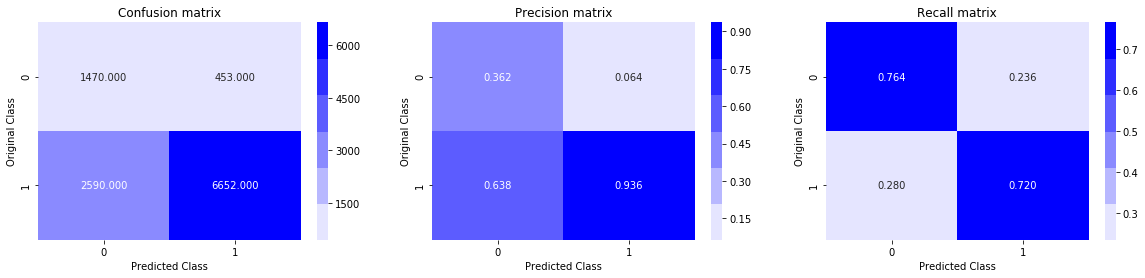

Recall value for the positive class of the model is: 0.7197576282190002
Precision value for the positive class of the model is: 0.9362420830401126
F1 score for the positive class of the model is: 0.8138496360188413


In [181]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [183]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_avgw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(sent_vectors_train)

final_grid_avgw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(sent_vectors_test)

final_grid_avgw2v_test_err=print_auc_score(y_true, y_scores)

print(final_grid_avgw2v_est)
print(final_grid_avgw2v_train_err)
print(final_grid_avgw2v_test_err)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
75.99630309609158
74.20941027210446


In [184]:
#RandomizedSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_distributions=tuned_parameters, 
                           scoring = 'roc_auc', cv=10, verbose=False)
model.fit(sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=227,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 127.38464760780334 seconds



The optimal value of max_depth is 5.


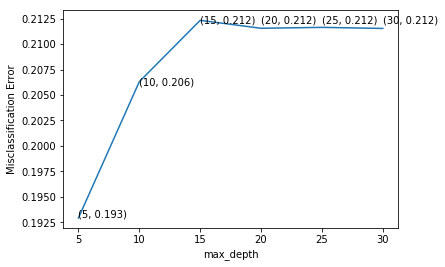

the misclassification error for each max_depth value is :  [0.193 0.206 0.212 0.212 0.212 0.212]


In [187]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(sent_vectors_train, final_train_Y)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(estimator=nb, X=sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 5  and minimum sample split = 227 is:  72.745186%
Confusion matrix for the model is:


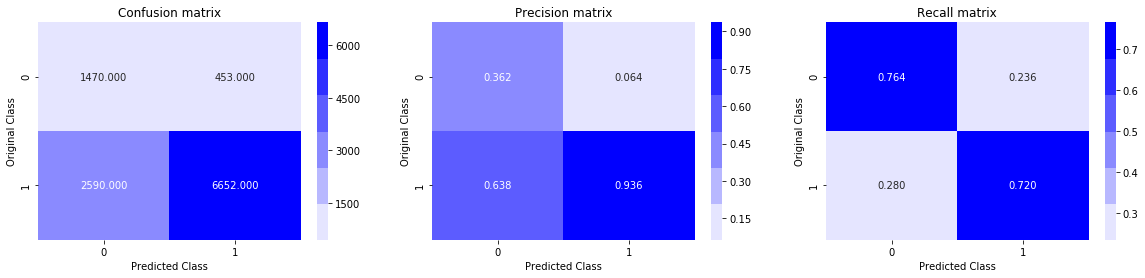

Recall value for the positive class of the model is: 0.7197576282190002
Precision value for the positive class of the model is: 0.9362420830401126
F1 score for the positive class of the model is: 0.8138496360188413


In [188]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [189]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_rand_avgw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(sent_vectors_train)

final_rand_avgw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(sent_vectors_test)

final_rand_avgw2v_test_err=print_auc_score(y_true, y_scores)

print(final_rand_avgw2v_est)
print(final_rand_avgw2v_train_err)
print(final_rand_avgw2v_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=227,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
75.99630309609158
74.20941027210446


# TF-IDF weighted Word2Vec

In [190]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in final_train_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = to_pass_tfidf_w2v_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

    
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
print(tfidf_sent_vectors_train[1])


# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in final_test_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = to_pass_tfidf_w2v_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

    
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
print(tfidf_sent_vectors_test[1])

26051
50
[ 0.50148869 -0.0565431   0.34478395  0.13784201  0.26883775 -0.13204654
 -0.08425451  0.39999518 -0.18646647  0.12294195 -0.08177401  0.19907811
 -0.13737442 -0.40053892  0.14011639  0.20941524 -0.28087457 -0.10181266
  0.36151839 -0.15856556 -0.09220446  0.02516993  0.42110108 -0.05031013
 -0.26682392  0.06843292  0.12402809 -0.17287205 -0.47981542 -0.25879475
 -0.27326258  0.19618709  0.01174783  0.09048673  0.17903233  0.1034281
 -0.42181798 -0.46872033  0.10620382  0.60925828 -0.52165277  0.40860781
 -0.05589822 -0.09557851 -0.41215511 -0.3600789   0.19844134  0.37072907
  0.04592498  0.10841169]
11165
50
[ 0.23112397 -0.03302373  0.27272789  0.11502491 -0.09206643 -0.05362383
  0.14197249  0.12401087 -0.16465723 -0.05142977 -0.06690476  0.21667563
  0.0082264  -0.33837159  0.04875335  0.32496002 -0.15653685 -0.10770755
  0.33484971 -0.30324736  0.05493294 -0.07122558  0.31827261 -0.08954791
 -0.22503456 -0.00136468  0.06466996 -0.2856493  -0.42875926 -0.2406951
 -0.25583

In [194]:
#We fould 1 review(19948) has all the vectors as Nan. So we are replacing it with 0
for i in range(len(tfidf_sent_vectors_train)):
    for j in range(50):
        if tfidf_sent_vectors_train[i][j] != tfidf_sent_vectors_train[i][j]:
            tfidf_sent_vectors_train[i][j]=0

In [195]:
#GridSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=tuned_parameters, 
                     scoring = 'roc_auc', cv=10, verbose=False)
model.fit(tfidf_sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=277,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 1161.2339022159576 seconds



The optimal value of max_depth is 5.


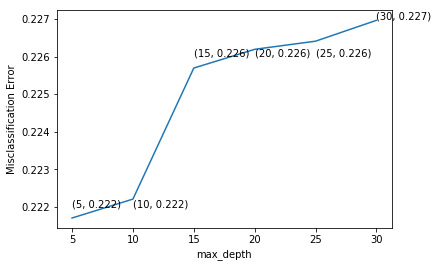

the misclassification error for each max_depth value is :  [0.222 0.222 0.226 0.226 0.226 0.227]


In [198]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(tfidf_sent_vectors_train, final_train_Y)
    scores = cross_val_score(estimator=nb, X=tfidf_sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 10  and minimum sample split = 277 is:  70.470219%
Confusion matrix for the model is:


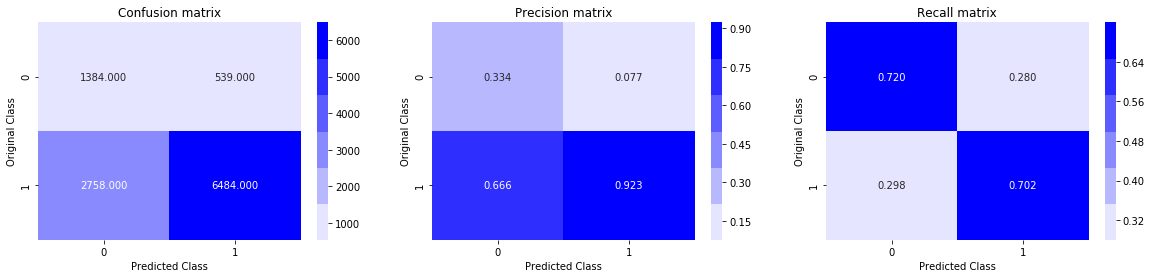

Recall value for the positive class of the model is: 0.7015797446440164
Precision value for the positive class of the model is: 0.923252171436708
F1 score for the positive class of the model is: 0.7972948047955732


In [199]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(tfidf_sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [201]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_tfidfw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_train)

final_grid_tfidfw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_test)

final_grid_tfidfw2v_test_err=print_auc_score(y_true, y_scores)

print(final_grid_tfidfw2v_est)
print(final_grid_tfidfw2v_train_err)
print(final_grid_tfidfw2v_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=277,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
77.67519310578321
71.06442664977752


In [202]:
#RandomizedSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_distributions=tuned_parameters, 
                           scoring = 'roc_auc', cv=10, verbose=False)
model.fit(tfidf_sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=77,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 156.08945894241333 seconds



The optimal value of max_depth is 5.


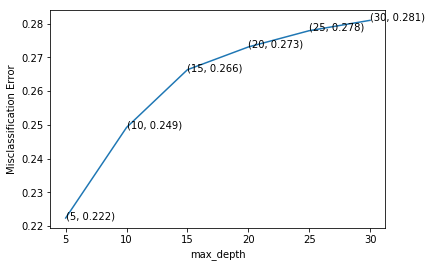

the misclassification error for each max_depth value is :  [0.222 0.249 0.266 0.273 0.278 0.281]


In [203]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(tfidf_sent_vectors_train, final_train_Y)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(estimator=nb, X=tfidf_sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 5  and minimum sample split = 77 is:  68.929691%
Confusion matrix for the model is:


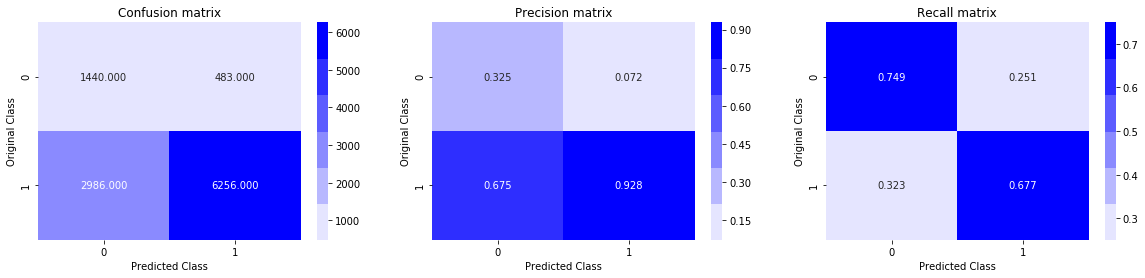

Recall value for the positive class of the model is: 0.6769097597922528
Precision value for the positive class of the model is: 0.9283276450511946
F1 score for the positive class of the model is: 0.7829297290532508


In [204]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(tfidf_sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [206]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_rand_tfidfw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_train)

final_rand_tfidfw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_test)

final_rand_tfidfw2v_test_err=print_auc_score(y_true, y_scores)

print(final_rand_tfidfw2v_est)
print(final_rand_tfidfw2v_train_err)
print(final_rand_tfidfw2v_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=77,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
73.93637544022533
71.28698564951902


### Error Metric Matrix

In [220]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Baseline Model", " Hyper Parameter", "Train Error", "Test Error"]
x.add_row(["GridSearch Cross Validation on Bag of Words", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_bow_est.max_depth, final_grid_bow_est.min_samples_split),
           "%.2f%%" % (100-final_grid_bow_train_err), "%.2f%%" %(100-final_grid_bow_test_err)])
x.add_row(["Random Cross Validation on Bag of Words", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_bow_est.max_depth, final_rand_bow_est.min_samples_split),
           "%.2f%%" % (100-final_rand_bow_train_err), "%.2f%%" %(100-final_rand_bow_test_err)])
#######################################################################################################
x.add_row(["GridSearch Cross Validation on TF-IDF", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_tfidf_est.max_depth, final_grid_tfidf_est.min_samples_split),
           "%.2f%%" % (100-final_grid_tfidf_train_err), "%.2f%%" %(100-final_grid_tfidf_test_err)])
x.add_row(["Random Cross Validation on TF-IDF", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_tfidf_est.max_depth, final_rand_tfidf_est.min_samples_split),
           "%.2f%%" % (100-final_rand_tfidf_train_err), "%.2f%%" %(100-final_rand_tfidf_test_err)])
#######################################################################################################
x.add_row(["GridSearch Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_avgw2v_est.max_depth, final_grid_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_grid_avgw2v_train_err), "%.2f%%" %(100-final_grid_avgw2v_test_err)])
x.add_row(["Random Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_avgw2v_est.max_depth,  final_rand_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_rand_avgw2v_train_err), "%.2f%%" %(100-final_rand_avgw2v_test_err)])
#######################################################################################################
x.add_row(["GridSearch Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_avgw2v_est.max_depth, final_grid_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_grid_avgw2v_train_err), "%.2f%%" %(100-final_grid_avgw2v_test_err)])
x.add_row(["Random Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_avgw2v_est.max_depth, final_rand_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_rand_avgw2v_train_err), "%.2f%%" %(100-final_rand_avgw2v_test_err)])
#######################################################################################################
x.add_row(["GridSearch Cross Validation on TF-IDF Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_tfidfw2v_est.max_depth,final_grid_tfidfw2v_est.min_samples_split),
           "%.2f%%" % (100-final_grid_tfidfw2v_train_err), "%.2f%%" %(100-final_grid_tfidfw2v_test_err)])
x.add_row(["Random Cross Validation on TF-IDF Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_tfidfw2v_est.max_depth,final_rand_tfidfw2v_est.min_samples_split),
           "%.2f%%" % (100-final_rand_tfidfw2v_train_err), "%.2f%%" %(100-final_rand_tfidfw2v_test_err)])
print(x)

+------------------------------------------------+---------------------------------------+-------------+------------+
|                 Baseline Model                 |             Hyper Parameter           | Train Error | Test Error |
+------------------------------------------------+---------------------------------------+-------------+------------+
|  GridSearch Cross Validation on Bag of Words   |  max_depth: 15, min_samples_split: 50 |    20.77%   |   28.17%   |
|    Random Cross Validation on Bag of Words     |  max_depth: 15, min_samples_split: 50 |    20.76%   |   27.88%   |
|     GridSearch Cross Validation on TF-IDF      | max_depth: 20, min_samples_split: 100 |    18.01%   |   27.26%   |
|       Random Cross Validation on TF-IDF        | max_depth: 20, min_samples_split: 251 |    19.10%   |   26.77%   |
|  GridSearch Cross Validation on Avg Word2Vec   |  max_depth: 5, min_samples_split: 252 |    24.00%   |   25.79%   |
|    Random Cross Validation on Avg Word2Vec     |  max_